# MFCC（Mel-Frequency Cepstrum Coefficient、メル周波数ケプストラム係数）
MFCCは聴覚フィルタに基づく音響分析手法で、主に音声認識の分野で使われることが多い。

## メル尺度
Stevensらによって提案された、人間の音高知覚が考慮された尺度。

1000Hzの純音の高さの感覚を1000メルと決めた上で、1000メルの半分の高さに感じた音を500メル、1000メルの2倍の高さに感じた音を2000メルという容量で定めたもの。

実験により、可聴域の下限に近い音は高め、上限に近い音は低めに聞こえることがわかっている。

メル尺度は基底膜上の座標とほとんど一致する。1000メルは基底膜の1cmに相当し、臨海帯域幅は約137メルに相当する。

周波数$f$をメル尺度$m$に変換する式は

$$
m = m_0\log(\frac{f}{f_0} + 1)
$$

逆変換は

$$
f = f_0(\exp\frac{m}{m_0} - 1)
$$

で与えられる。

$f_0$は自由パラメータの周波数パラメータであり、$m_0$は「1000Hzは1000メル」という成約から導かれる

$$
m_0 = \frac{1000}{\log(\frac{1000\mathrm{Hz}}{f_0} + 1)}
$$

であらわされる縦続パラメータである。

よく用いられるパラメータとして

$$
f_0 = 700, m_0 = 2595
$$

がある。

## ケプストラム
音声信号のフーリエ変換の絶対値に対数をかけ、さらに逆フーリエ変換（フーリエ変換とする場合もある）したもの。

信号$x(n)$のフーリエ変換を$X(e^{j\omega}$とすると、ケプストラム$c(m)$は

$$
c(m) = \frac{1}{2\pi}\int_{\pi}^{\pi}\log|X(e^{j\omega})|e^{j\omega n}d\omega
$$

高ケフレンシ領域は微細振動（音声でいうと声帯の振動）、低ケフレンシ領域はスペクトル包絡（音声でいうと声道フィルタの特性）を表す。

リフタリング処理を施すことによってこれらを分離することができる。

## 変換手順

[この記事](http://aidiary.hatenablog.com/entry/20120225/1330179868)を参考にしながら実際に変換してみる。

今回は「あ」の音声波形の定常部分のMFCCを求めてみる。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

### 1. 波形を適当な長さに分割し、窓関数をかけてFFTを行う

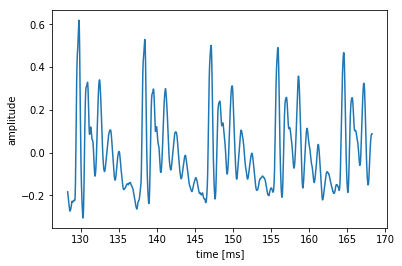

In [3]:
# 音声の読み込み
master, fs = sf.read('wavfiles/a_1.wav')

t = np.arange(0, len(master) / fs, 1/fs)

# 音声波形の中心部分（定常部）を切り出す
center = len(master)//2 #　中心のサンプル番号
cuttime = 0.04 # 秒
x = master[int(center - cuttime / 2 * fs):int(center + cuttime / 2 * fs)]
time = t[int(center - cuttime/2*fs): int(center + cuttime/2*fs)]

plt.plot(time * 1000, x)
plt.xlabel("time [ms]")
plt.ylabel("amplitude")
plt.show()

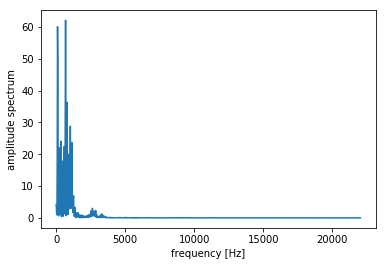

In [4]:
# ハミング窓をかける
hamming = np.hamming(len(x))
x = x * hamming

# 振幅スペクトルを求める
N = 2048 # FFTのサンプル数
spec = np.abs(np.fft.fft(x, N))[:N//2]
fscale = np.fft.fftfreq(N, d = 1.0 / fs)[:N//2]

plt.plot(fscale, spec)
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude spectrum")
plt.show()

### 2.メルフィルタバンクをかける

フィルタバンクとは、複数のバンドパスフィルタを並べたものである。

MFCCでは三角形のバンドパスフィルタをオーバラップさせながら並べ、フィルタバンクとしたメルフィルタバンクを用いる。

メルフィルタバンクは周波数領域での三角窓がメル尺度上で等間隔になるように並べたものであり、低周波ほど幅が狭く、高周波ほど幅が広くなる。

並べられたバンドパスフィルタの数をチャンネル数という。

まずは周波数とメル尺度を変換する関数を実装する。

In [5]:
def hz2mel(f):
    """Hzをmelに変換"""
    return 2595 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700 * (np.exp(m / 2595) - 1.0)

次にメルフィルタバンクを作る関数を実装する。

[  13.   21.   31.   42.   55.   71.   90.  112.  138.  169.  205.  248.
  299.  358.  429.  512.  610.  726.  863. 1024.]


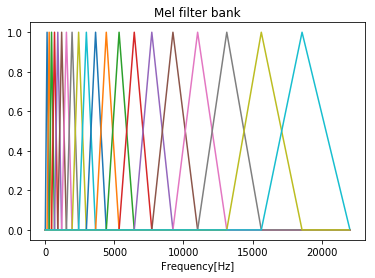

In [6]:
def melFilterBank(fs, N, numChannels):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数（Hz）
    fmax = fs / 2
    # ナイキスト周波数（mel）
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = N // 2
    # 周波数解像度（周波数インデックス1あたりのHz幅）
    df = fs / N
    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))
    filterbank = np.zeros((numChannels, nmax))
    print(indexstop)
    for c in range(0, numChannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in range(int(indexstart[c]), int(indexcenter[c])):
            filterbank[c, i] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in range(int(indexcenter[c]), int(indexstop[c])):
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

# メルフィルタバンクを作成
numChannels = 20  # メルフィルタバンクのチャネル数
df = fs / N   # 周波数解像度（周波数インデックス1あたりのHz幅）
filterbank, fcenters = melFilterBank(fs, N, numChannels)

# メルフィルタバンクのプロット
for c in np.arange(0, numChannels):
    plt.plot(np.arange(0, N / 2) * df, filterbank[c])
    
plt.title('Mel filter bank')
plt.xlabel('Frequency[Hz]')
plt.show()

次に振幅スペクトルにメルフィルタバンクをかける。

振幅スペクトルに対して作成した各フィルタバンクをかけ、フィルタリングされた振幅を足し合わせて対数を取る。

forループを使って書いてもよいが、内積の形でも書ける。

In [7]:
# 振幅スペクトルにメルフィルタバンクを適用
mspec = np.dot(spec, filterbank.T)

元の振幅スペクトルとフィルタバンクをかけた後のスペクトルを比べてみる。

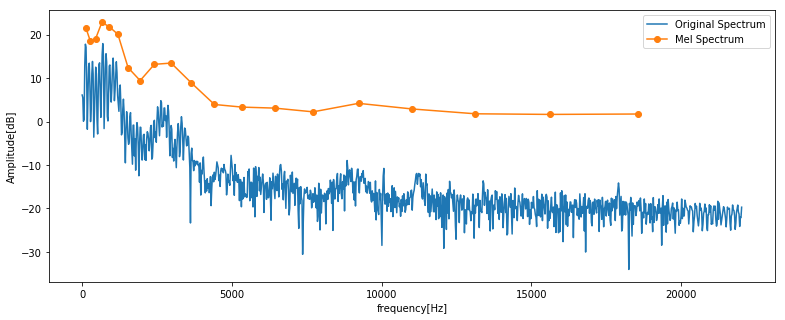

In [8]:
# 元の振幅スペクトルとフィルタバンクをかけて圧縮したスペクトルを表示
plt.figure(figsize=(13, 5))

plt.plot(fscale, 10* np.log10(spec), label='Original Spectrum')
plt.plot(fcenters, 10 * np.log10(mspec), "o-", label='Mel Spectrum')
plt.xlabel("frequency[Hz]")
plt.ylabel('Amplitude[dB]')
plt.legend()
plt.show()

### 3.離散コサイン変換を行う

ケフレンシ空間に戻すために離散コサイン変換を行う。

離散コサイン変換を行う理由として、係数間の相関が減り、特徴量としての性能が向上するなどがある。

離散コサイン変換の結果から低次の係数を取り出すと、MFCCが得られる。大体12次まで取ることが多い。

In [9]:
from scipy.fftpack.realtransforms import dct

ceps = dct(mspec, type=2, norm="ortho", axis=-1)
nceps = 12
mfcc = ceps[:nceps]
print(mfcc)

[185.60782114 200.56668729  92.15345128   1.16538975 -47.4746488
 -60.60365351 -43.46459693   3.15481979  50.37136343  64.6038092
  48.42430931  27.41620554]


## LibrosaでMFCCを求める

上では音声データ全体の中の１フレームのみを用いてMFCCを求めたが、Librosaを使うと簡単に各フレームごとのMFCCを求めることができる。

In [10]:
import librosa

x, fs = sf.read('wavfiles/a_1.wav')
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)
print(mfccs[0])

(20, 26)
[-299.48698558 -306.19008252 -281.77019349 -205.61561205 -165.07338147
 -182.40750356 -172.10454081 -175.49027956 -191.51493931 -210.77326972
 -217.29547751 -223.91082068 -232.23909119 -247.65589292 -256.91669445
 -263.66001621 -275.46132992 -299.72892089 -288.90436044 -262.39782466
 -252.39945491 -256.61596037 -260.47453287 -274.17839766 -299.54783037
 -342.87809203]


カラーマップを用いて可視化することもできる。

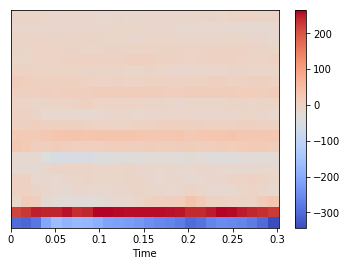

In [11]:
import librosa.display

librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.colorbar()

##  参考

[リアルタイム音声認識（安藤彰夫　著）](https://www.amazon.co.jp/%E3%83%AA%E3%82%A2%E3%83%AB%E3%82%BF%E3%82%A4%E3%83%A0%E9%9F%B3%E5%A3%B0%E8%AA%8D%E8%AD%98-%E5%AE%89%E8%97%A4-%E5%BD%B0%E7%94%B7/dp/4885521955/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&keywords=%E3%83%AA%E3%82%A2%E3%83%AB%E3%82%BF%E3%82%A4%E3%83%A0%E9%9F%B3%E5%A3%B0%E8%AA%8D%E8%AD%98&qid=1559118922&s=gateway&sr=8-1)

https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f

http://aidiary.hatenablog.com/entry/20120225/1330179868

https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E5%B0%BA%E5%BA%A6

http://abcpedia.acoustics.jp/acoustic_feature_2.pdf